In [1]:
import logging
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch
import os


import torch
import lava.lib.dl.slayer as slayer
from lava.lib.dl import netx

import numpy as np

from lava.lib.dl.slayer.state_space_models.sCIFAR.networks import SCIFARNetworkSlayer
from lava.lib.dl.slayer.state_space_models.sCIFAR import utils
from lava.proc.receiver.process import Receiver
from lava.proc.spike_injector.process import InputProcess

from lava.proc.io.source import RingBuffer as SourceBuffer
from lava.proc.io.sink import RingBuffer as SinkBuffer
from lava.proc.embedded_io.spike import PyToNxAdapter, NxToPyAdapter
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2HwCfg
from lava.proc.dense.process import Dense
from lava.proc.sdn.process import ActivationMode
from lava.proc.s4d.process import SigmaS4dDelta, S4d
from lava.proc.sparse.process import Sparse
from lava.proc.spike_integrator.process import SpikeIntegrator, SpikeIntegrator32



from lava.magma.core.run_conditions import RunSteps
from lava.proc.lif.process import LIF
from lava.proc.dense.process import Dense
from lava.magma.compiler.subcompilers.nc.ncproc_compiler import CompilerOptions
from lava.utils.profiler import Profiler
from lava.lib.dl.slayer.state_space_models.sCIFAR.networks import SCIFARNetworkTorch
from lava.lib.dl.slayer.state_space_models.sCIFAR import utils
from lava.proc.receiver.process import Receiver
from lava.proc.spike_injector.process import InputProcess


import os
from lava.utils.system import Loihi2

loihi2_is_available = Loihi2.is_loihi2_available
if loihi2_is_available:
    # Enable SLURM, the workload manager used to distribute Loihi2 resources to users
    os.environ['SLURM'] = '1'
    os.environ['PARTITION'] = "oheogulch"
    os.environ['LOIHI_GEN'] = "N3C1"
    #os.environ["NXOPTIONS"] = "--vdd=0.65,--vddm=0.8"
import numpy as np


np.set_printoptions(linewidth=110)  # Increase the line lenght of output cells.
n_steps = 6000 #1024 # 1000 works

CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


In [2]:
_, _, val_loader = utils.get_datasets() 
label, data_sample = next(enumerate(val_loader)) 
label, data_sample = next(enumerate(val_loader))

Files already downloaded and verified
Files already downloaded and verified


In [3]:
data_sample_final = data_sample[0].detach().numpy().squeeze()  * 2**12

print(data_sample_final.shape)

(1024, 3)


data_sample_final
final_string = "{"
for row in data_sample_final:
    for idx, col in enumerate(row):
        final_string += str(int(col)) 
        if idx in [0,1]:
            final_string += ", "
    final_string += "},\n {"
print(final_string)

In [4]:
d_model=128
n_states=4
lava_dl_model_trained = SCIFARNetworkSlayer(d_model=d_model, n_states=n_states, num_layers=1, get_last=False)
lava_dl_model_trained.load_state_dict(torch.load("./../training_logs/Trained_slayer_quantized/network_quantized.pt"))
lava_dl_model_trained.eval()
out_dl_trained = lava_dl_model_trained(data_sample[0])

if os.path.exists("./../training_logs/netx_trained.net"):
    os.remove("./../training_logs/netx_trained.net")
lava_dl_model_trained.export_hdf5("./../training_logs/netx_trained.net")
num_message_bits = 24

loaded_net =  netx.hdf5.Network(net_config="./../training_logs/netx_trained.net", input_message_bits=num_message_bits, sparse_fc_layer=True, skip_layers=1)
print(loaded_net)

|   Type   |  W  |  H  |  C  | ker | str | pad | dil | grp |delay|
|Dense     |    1|    1|  128|     |     |     |     |     |False|
|Dense     |    1|    1|  512|     |     |     |     |     |False|
|Dense     |    1|    1|  128|     |     |     |     |     |False|
|Dense     |    1|    1|  128|     |     |     |     |     |False|
|Dense     |    1|    1|   10|     |     |     |     |     |False|


#### Create Lava Network

In [5]:
def example_run(net, profile, sample_num):
    input = InputProcess(shape=(3,), sample_num=sample_num, num_message_bits=24)
    dense_to_on_chip = Dense(weights=np.eye(10), num_message_bits=24)  
    on_chip_receiver = Receiver(shape=(10,))
    
    input.out_port.connect(net.inp)
    net.out.connect(dense_to_on_chip.s_in)
    dense_to_on_chip.a_out.connect(on_chip_receiver.a_in)
    
    run_cfg = Loihi2HwCfg()
    
    # set up profiler
    if profile == "energy":
        profiler = Profiler.init(run_cfg)
        profiler.energy_probe(num_steps=n_steps)
        profiler.activity_probe()
        profiler.memory_probe()
    elif profile == "time":
        profiler = Profiler.init(run_cfg)
        profiler.execution_time_probe(num_steps=n_steps)
    else:
        profiler = None

    
    on_chip_receiver.run(
                    condition=RunSteps(num_steps=n_steps), run_cfg=run_cfg
                    )
    on_chip_receiver.stop()
    return profiler






In [6]:
power_results = np.zeros((5, 5)) 
time_results =  np.zeros((5, 5))

for idx, thres in enumerate([0, 0.1, 5]):
    lava_dl_model_trained = SCIFARNetworkSlayer(d_model=d_model, n_states=n_states, threshold=thres, num_layers=1, get_last=False)
    lava_dl_model_trained.load_state_dict(torch.load("./../training_logs/Trained_slayer_quantized/network_quantized.pt"))
    lava_dl_model_trained.eval()
    out_dl_trained = lava_dl_model_trained(data_sample[0])

    if os.path.exists("./../training_logs/netx_trained.net"):
        os.remove("./../training_logs/netx_trained.net")
    lava_dl_model_trained.export_hdf5("./../training_logs/netx_trained.net")

    for sample in range(6, 11):
        loaded_net =  netx.hdf5.Network(net_config="./../training_logs/netx_trained.net", input_message_bits=num_message_bits, sparse_fc_layer=True, skip_layers=1)
        energy_profiler = example_run(loaded_net, "energy", sample)
        net =  netx.hdf5.Network(net_config='./../training_logs/netx_trained.net', input_message_bits=num_message_bits, sparse_fc_layer=True, skip_layers=1)
        time_profiler = example_run(net, "time", sample)
        time_results[sample%5, idx]= (np.round(np.sum(time_profiler.execution_time), 6))
        power_results[sample%5, idx] = (np.round(energy_profiler.power, 6)) 

Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Partitioning converged after iteration=1
Per core utilization:
-------------------------------------------------------------------------
| AxonIn |NeuronGr| Neurons|Synapses| AxonMap| AxonMem|  Total |  Cores |
|-----------------------------------------------------------------------|
|   0.06%|  12.50%|   0.24%|   0.19%|   0.06%|   0.00%|   0.30%|       1|
|   0.80%|  12.50%|   0.24%|   2.39%|   0.06%|   0.00%|   2.66%|       1|
|   0.80%|  12.50%|   3.13%|  30.60%|   0.80%|   0.00%|  26.41%|       1|
|   3.20%|  12.50%|   3.13%|   3.20%|   0.80%|   0.00%|   6.41%|       1|
|   0.80%|  12.50%|  25.01%|   0.80%|   3.20%|   0.00%|   8.96%|       1|
|   0.02%|  12.50%|   3.13%|   0.66%|   0.80%|   0.00%|   1.83%|       1|
|-----------------------------------------------------------------------|
| Total                                                        |       6|
-------------------------------------------------------------------------


/home/sveamari/lava_dev/frameworks.ai.nx.nxsdk/nxcore/arch/n3b/n3board.py:77: UserWarning: Loihi generation overriden by environment variable LOIHI_GEN=N3C1
  warnings.warn("Loihi generation overriden by environment variable LOIHI_GEN={}".format(os.environ["LOIHI_GEN"]))


Text(0.5, 1.0, 'Power Measurement for 5 runs of S4D')

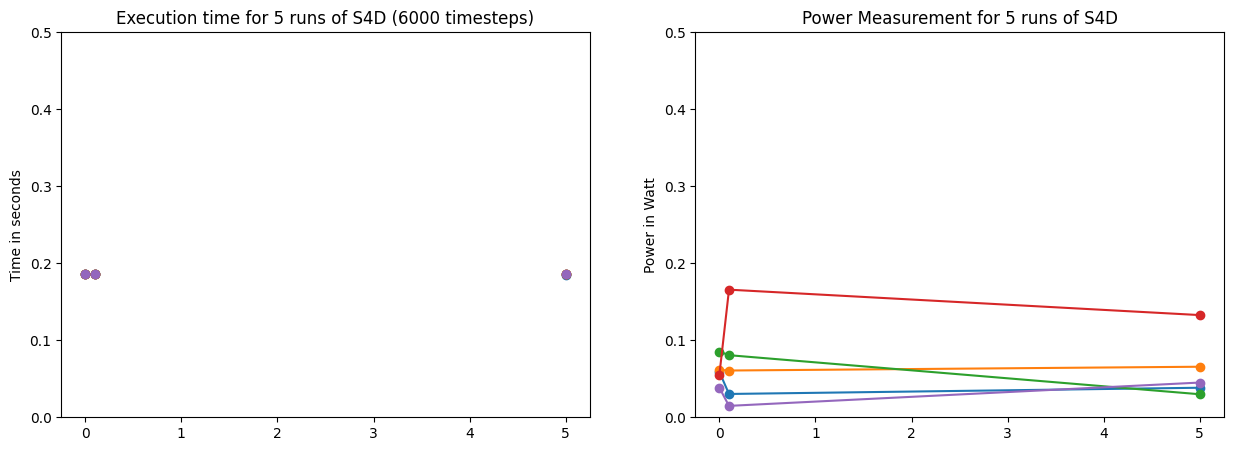

In [7]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
thres = [0, 0.1, 5]
# add yrange
for i in range(5):
    ax[0].plot(thres, time_results[i, :3], marker= "o", linestyle = "")
    ax[1].plot(thres, power_results[i, :3], marker= "o")
ax[0].set_ylim([0, 0.5])
ax[0].set_ylabel("Time in seconds")
ax[0].set_title("Execution time for 5 runs of S4D (6000 timesteps)")
ax[1].set_ylim([0, 0.5])
# set y label
ax[1].set_ylabel("Power in Watt")
ax[1].set_title("Power Measurement for 5 runs of S4D")

# i dont want the markers to be connected

In [8]:
print(f"Total execution time: {np.round(np.sum(time_profiler.execution_time), 6)} s")
print(f"Total power: {np.round(energy_profiler.power, 6)} W") 
print(f"Total energy: {np.round(energy_profiler.energy, 6)} J")
print(f"Static energy: {np.round(energy_profiler.static_energy, 6)} J") 

Total execution time: 0.185119 s
Total power: 0.038364 W
Total energy: 0.007095 J
Static energy: 0.018895 J


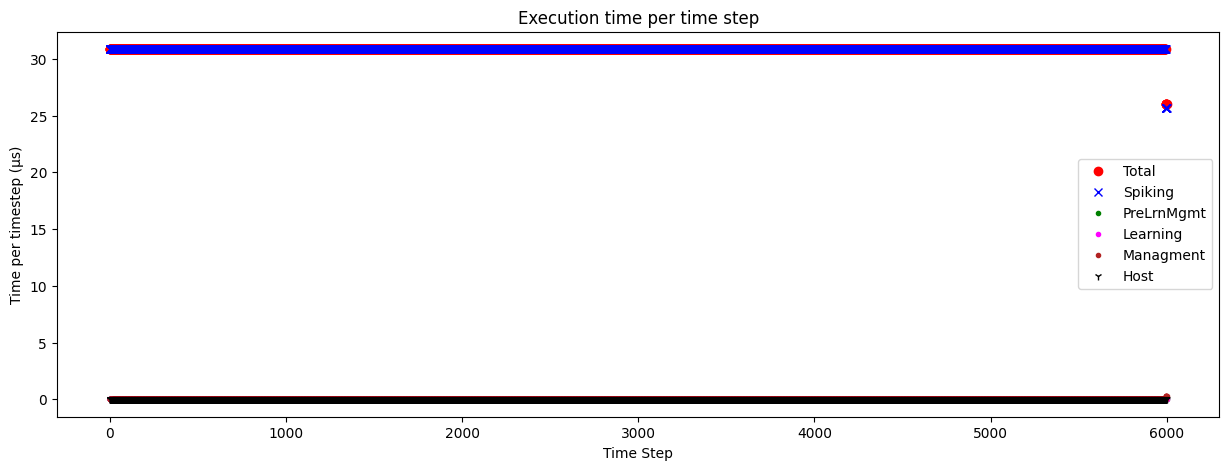

In [9]:
time_profiler.plot_execution_time()

In [10]:
# to-do:
#- create csnips for 10 data_samples with/without difference
#- allow for changing the threshold
#- for all 10 datasamples get it for different thresholds
#- for all 10 datasamples get it for the non SigmaDelta version 

In [11]:
energy_profiler.statement

The workload ran on a Loihi 2 system with 1 available chips and occupied 1 chips.


Total Power   : 0.038364 W
Dynamic Power : -0.063803 W
Static Power  : 0.102167 W
VDD Power     : 0.000909 W
VDD-M Power   : 0.026364 W
VDD-IO Power  : 0.011091 W
Total Energy   : 7095.00 µJ
Dynamic Energy : -11800.00 µJ
Static Energy  : 18895.00 µJ
VDD Energy     : 168.00 µJ
VDD-M Energy   : 4876.00 µJ
VDD-IO Energy  : 2051.00 µJ


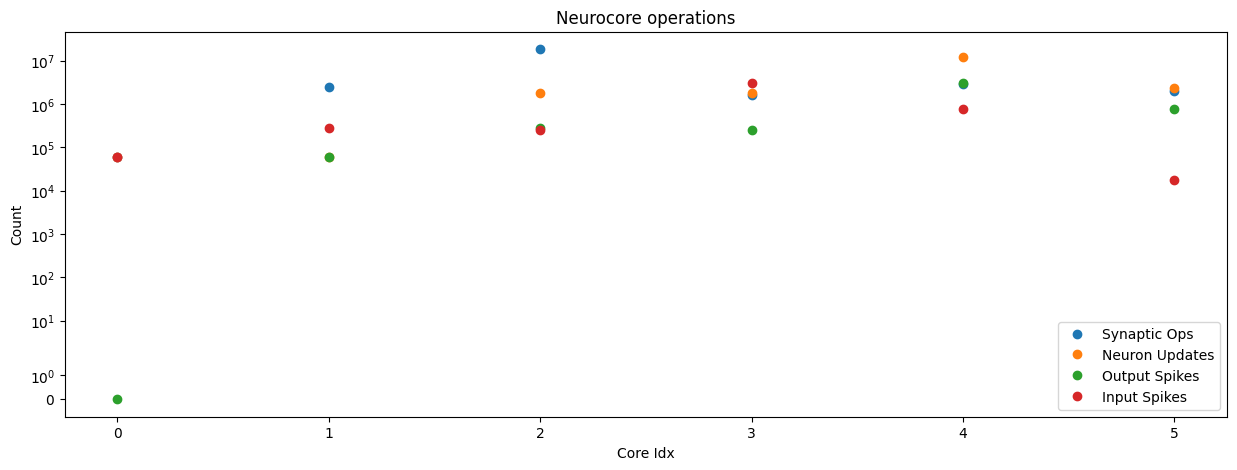

In [12]:
energy_profiler.power_breakdown()
energy_profiler.energy_breakdown()
energy_profiler.plot_activity()
